In [1]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [11]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [12]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [13]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [14]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue
    
    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue
    
    # Assuming there's only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]
    
    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230801_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230801_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230824_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230824_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230901_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230901_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230902_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230902_train.shp


In [15]:
# Double check the shapefiles all have the same column names to avoid further issues 

import fiona

# Iterate through shapefile paths
for shapefile_path in shapefile_paths:
    # Open the shapefile
    with fiona.open(shapefile_path) as shp:
        # Print the column names
        print(f"Shapefile: {shapefile_path}")
        print("Column names:", shp.schema['properties'].keys())
        print()


Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230801_train.shp
Column names: dict_keys(['Id', 'Field', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230824_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230901_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230902_train.shp
Column names: dict_keys(['Id', 'label'])


In [16]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [17]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)


In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

In [19]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.96      0.99      0.97        71
         ice       1.00      1.00      1.00        48
       ocean       0.99      1.00      1.00       101
        rock       1.00      0.90      0.95        20
walrus_mixed       0.95      0.94      0.94        77
 walrus_pure       0.62      0.62      0.62         8

    accuracy                           0.97       325
   macro avg       0.92      0.91      0.91       325
weighted avg       0.97      0.97      0.97       325


In [21]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


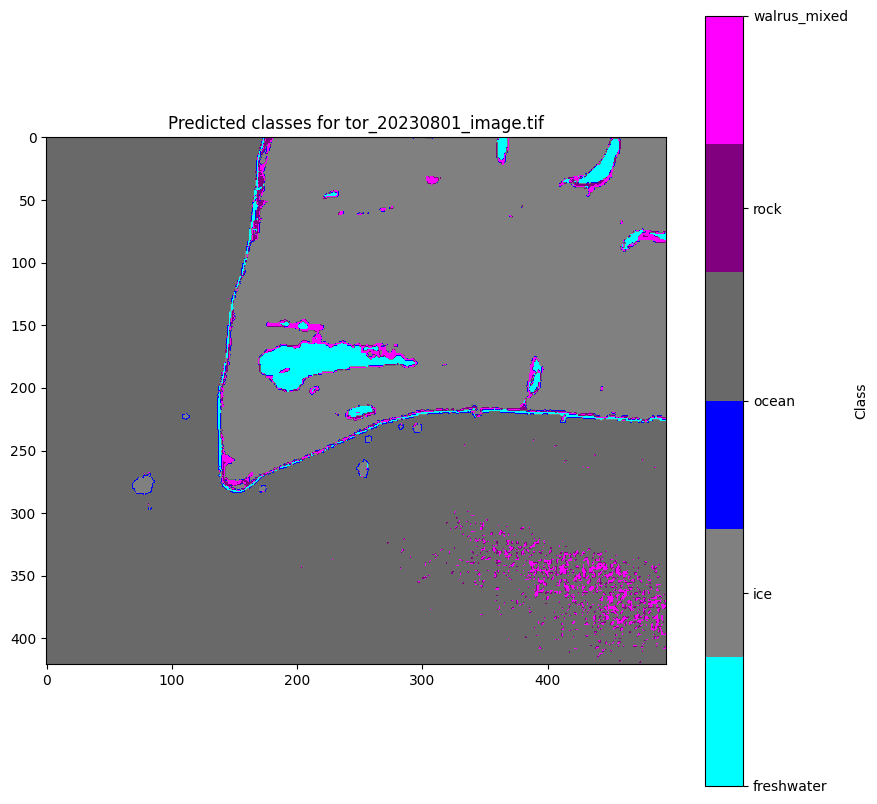

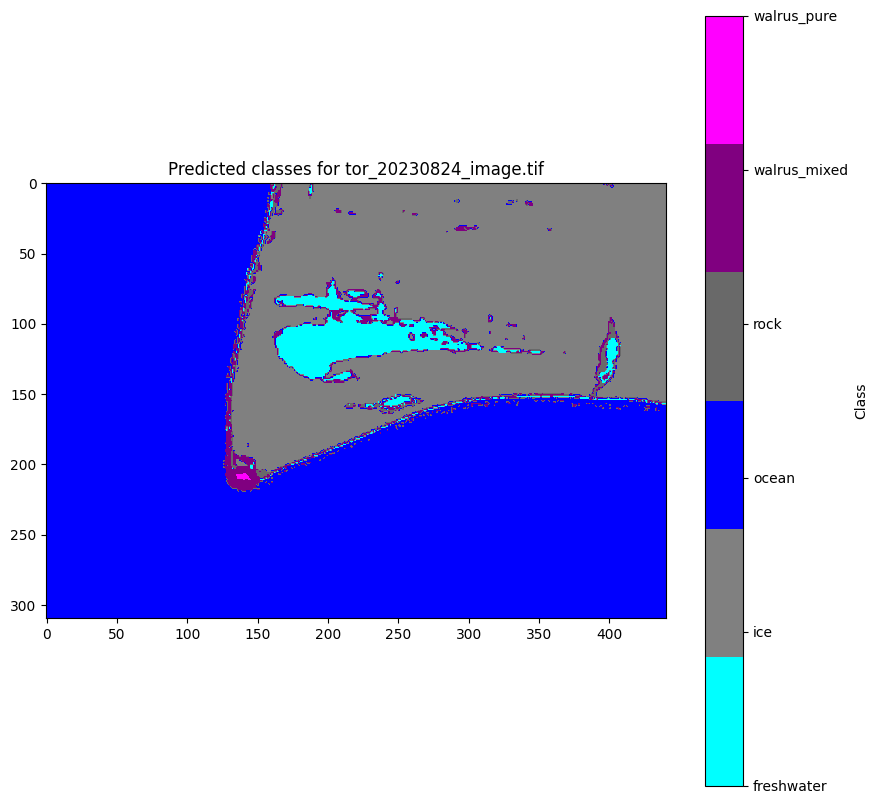

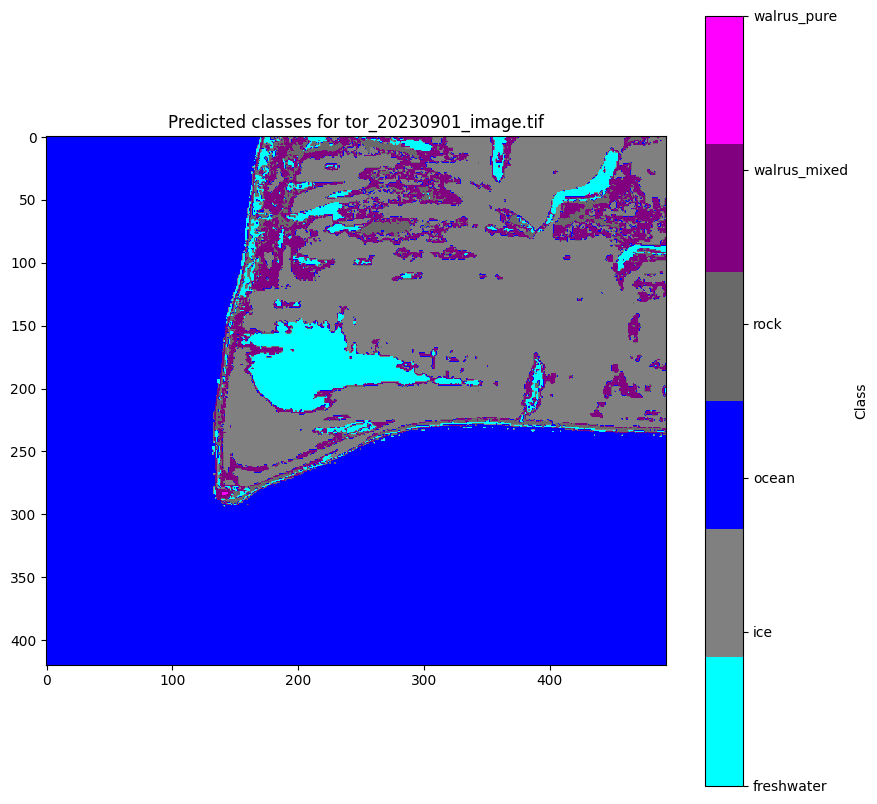

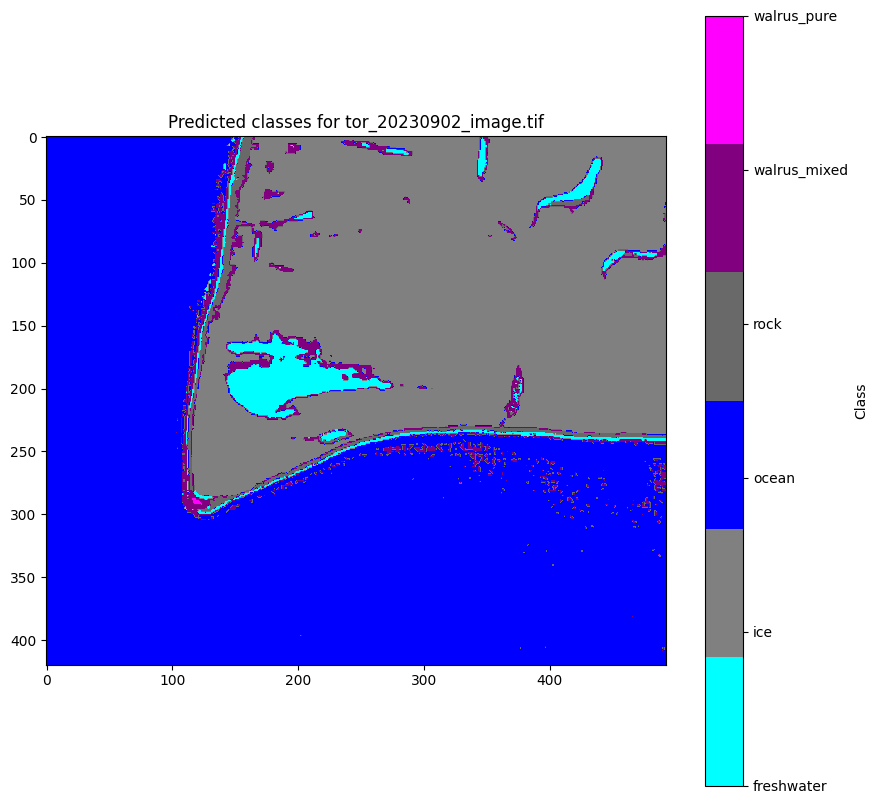

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a color map for the labels
label_colors = {'ice': 'gray', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

for image_path, predicted_image in predicted_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    plt.show()


In [50]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [51]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [52]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [53]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue
    
    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue
    
    # Assuming there's only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]
    
    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230801_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230801_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230824_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230824_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230901_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230901_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230902_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230902_train.shp


In [54]:
# Double check the shapefiles all have the same column names to avoid further issues 

import fiona

# Iterate through shapefile paths
for shapefile_path in shapefile_paths:
    # Open the shapefile
    with fiona.open(shapefile_path) as shp:
        # Print the column names
        print(f"Shapefile: {shapefile_path}")
        print("Column names:", shp.schema['properties'].keys())
        print()


Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230801_train.shp
Column names: dict_keys(['Id', 'Field', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230824_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230901_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\tor_20230902_train.shp
Column names: dict_keys(['Id', 'label'])


In [55]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [56]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)


In [57]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

In [58]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [59]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.97      0.94      0.96      1069
         ice       0.99      1.00      0.99     15275
       ocean       1.00      1.00      1.00     37900
        rock       0.80      0.34      0.48       230
walrus_mixed       1.00      0.70      0.82        47
 walrus_pure       0.77      0.91      0.83        11

    accuracy                           0.99     54532
   macro avg       0.92      0.82      0.85     54532
weighted avg       0.99      0.99      0.99     54532


In [60]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


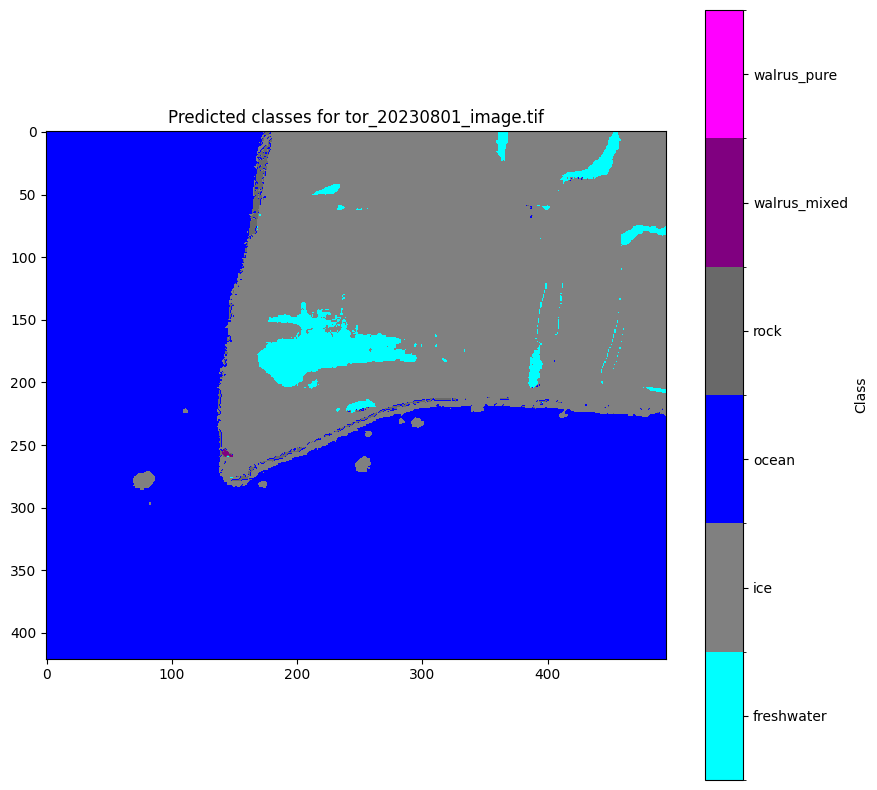

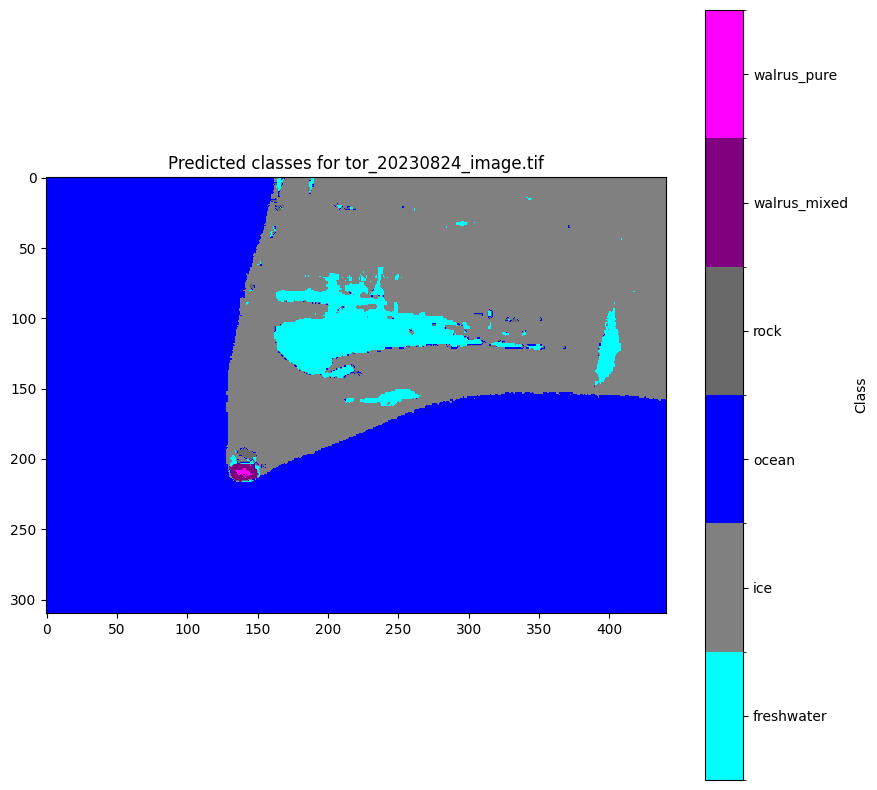

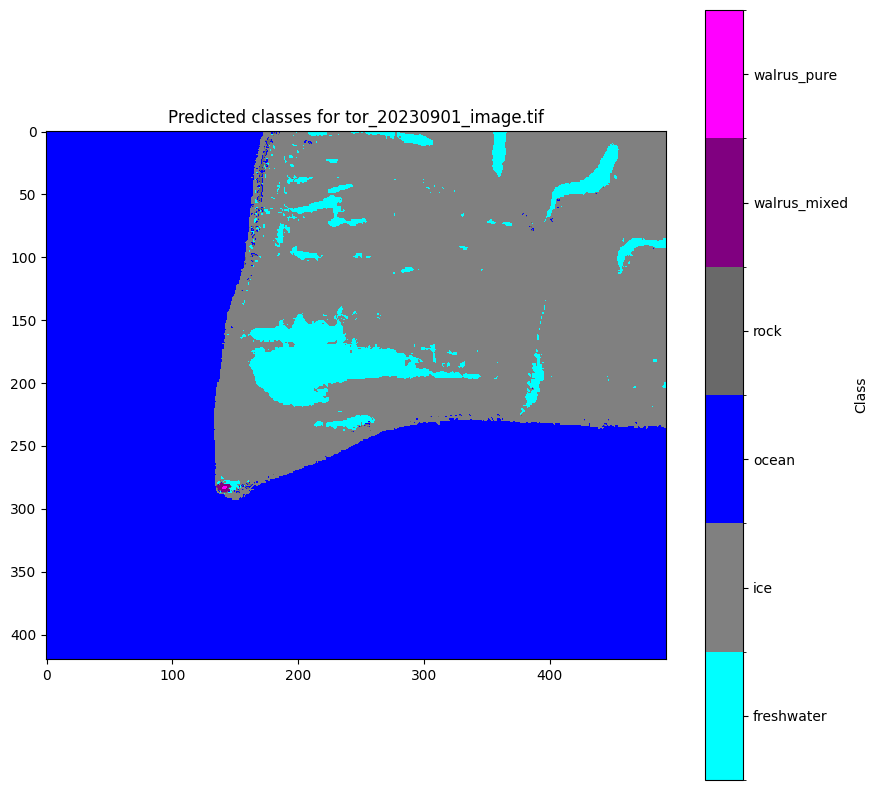

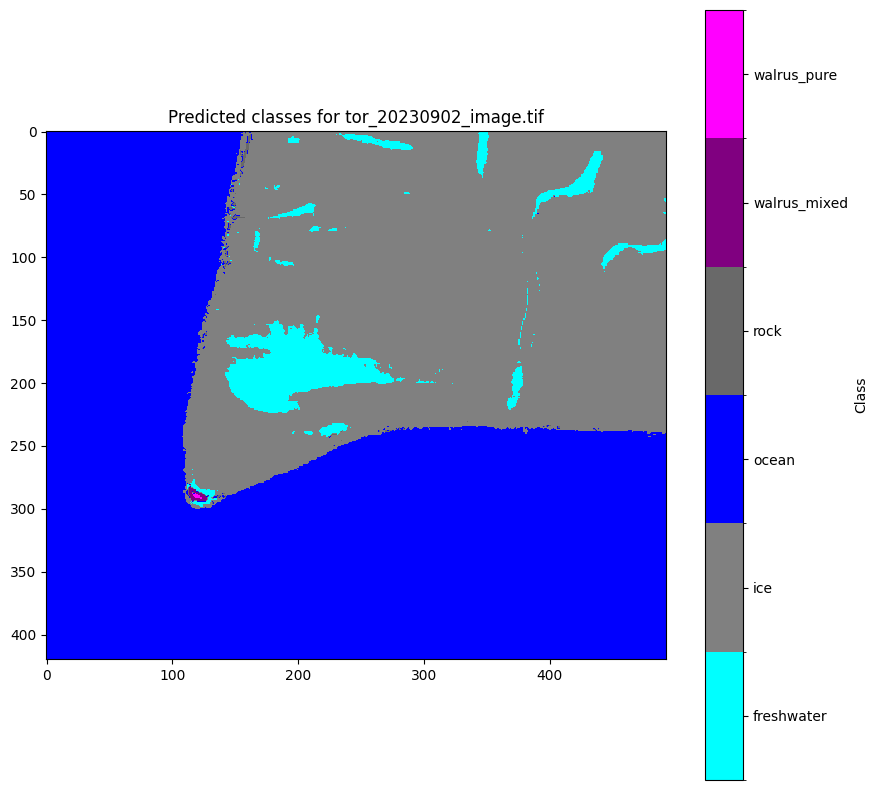

In [61]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a color map for the labels
label_colors = {'ice': 'gray', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue', 'stain': 'red'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(le.classes_)+1)-0.5, ncolors=len(le.classes_))

for image_path, predicted_image in predicted_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    plt.show()


In [64]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [65]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [66]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue
    
    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue
    
    # Assuming there's only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]
    
    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Sha

In [67]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [68]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.97      0.94      0.96      1069
         ice       0.99      1.00      0.99     15275
       ocean       1.00      1.00      1.00     37900
        rock       0.80      0.34      0.48       230
walrus_mixed       1.00      0.70      0.82        47
 walrus_pure       0.77      0.91      0.83        11

    accuracy                           0.99     54532
   macro avg       0.92      0.82      0.85     54532
weighted avg       0.99      0.99      0.99     54532


In [69]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


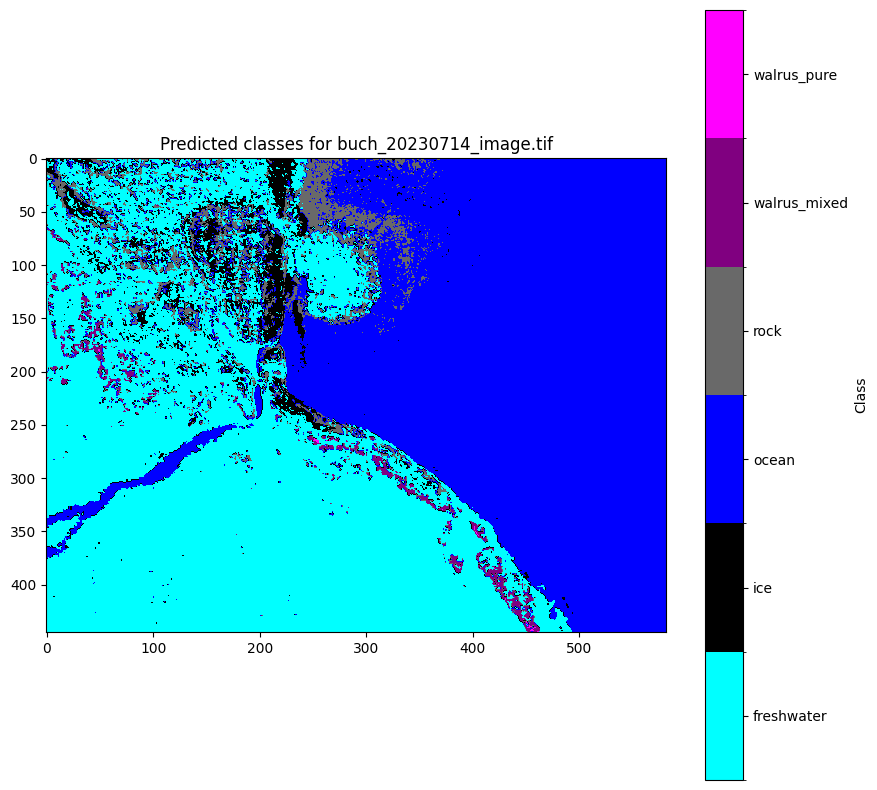

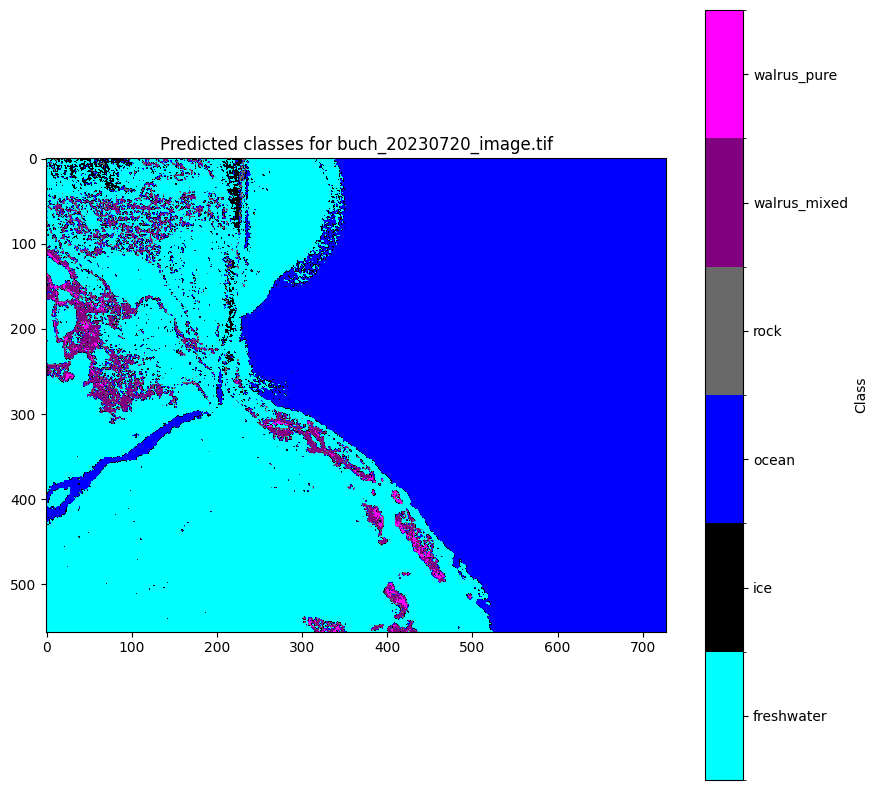

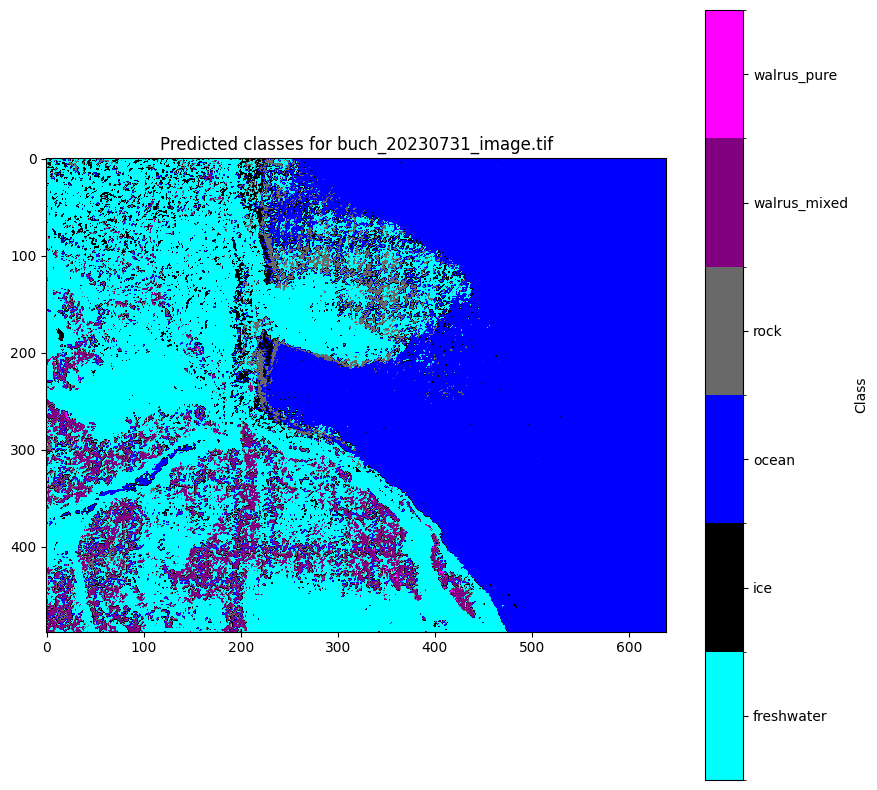

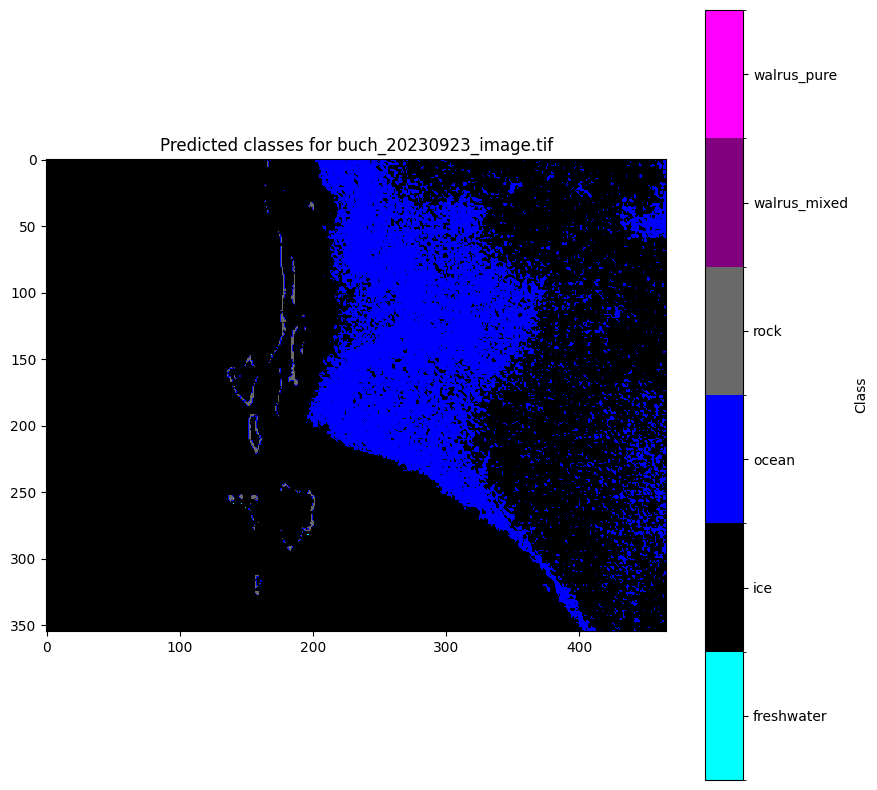

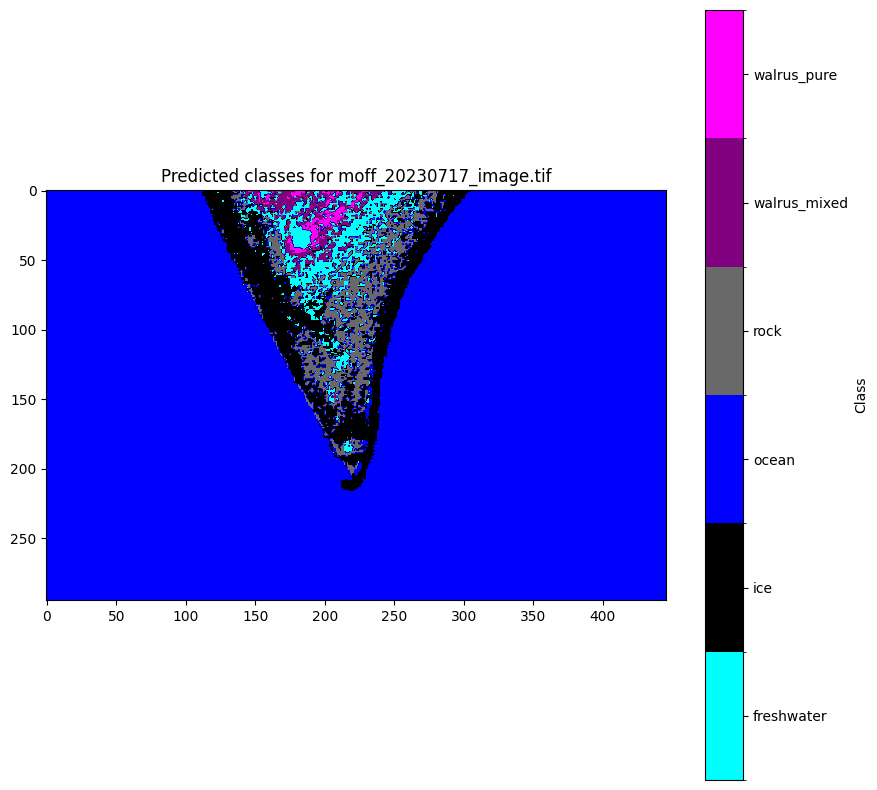

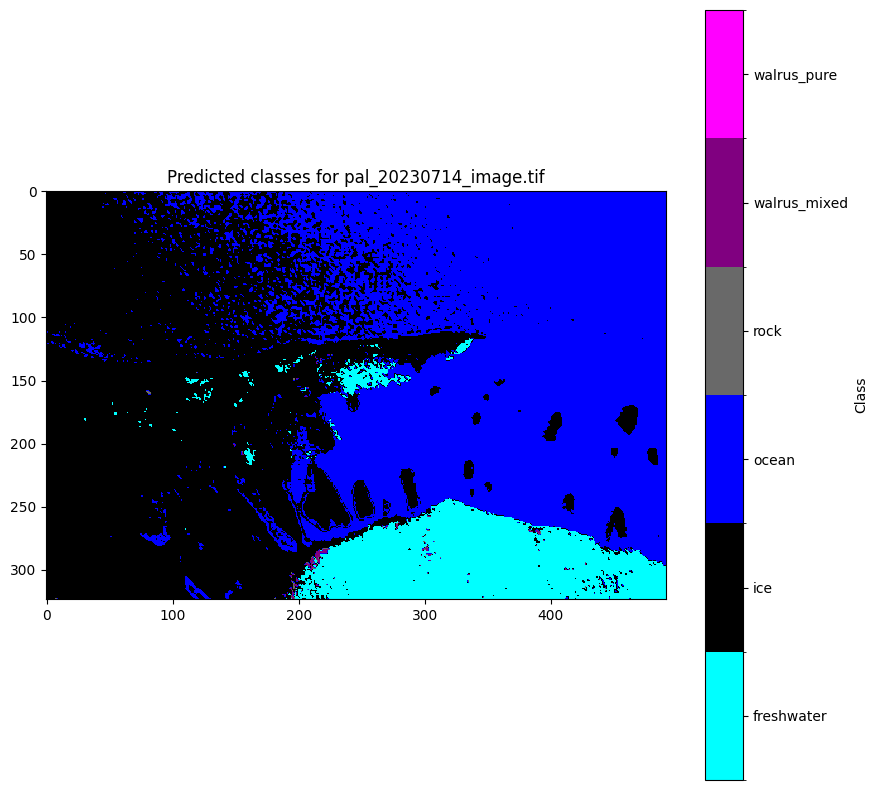

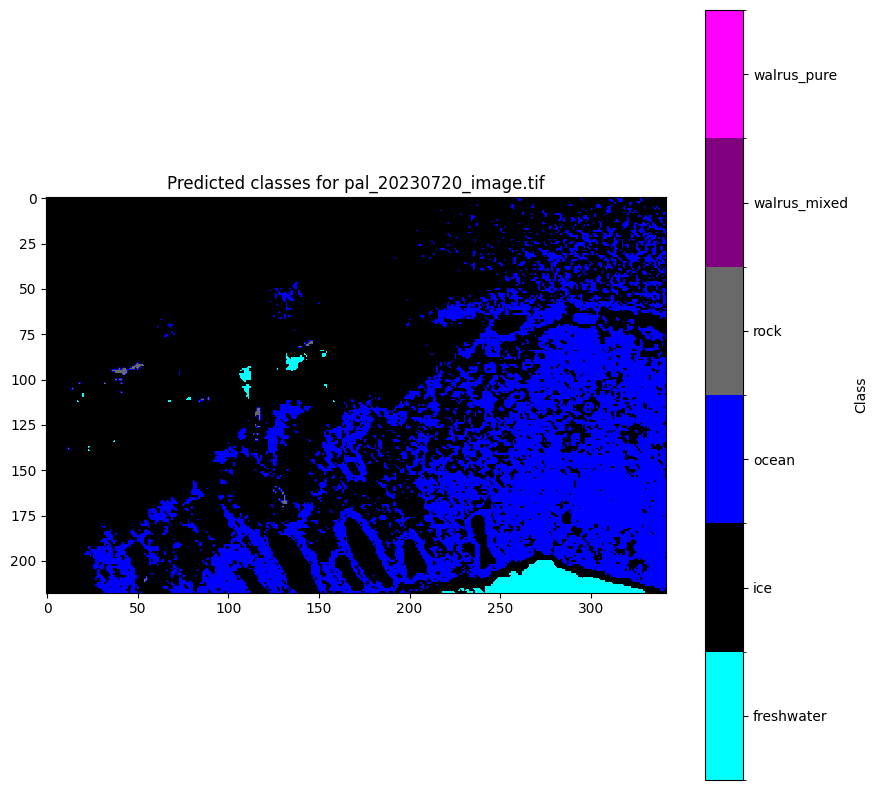

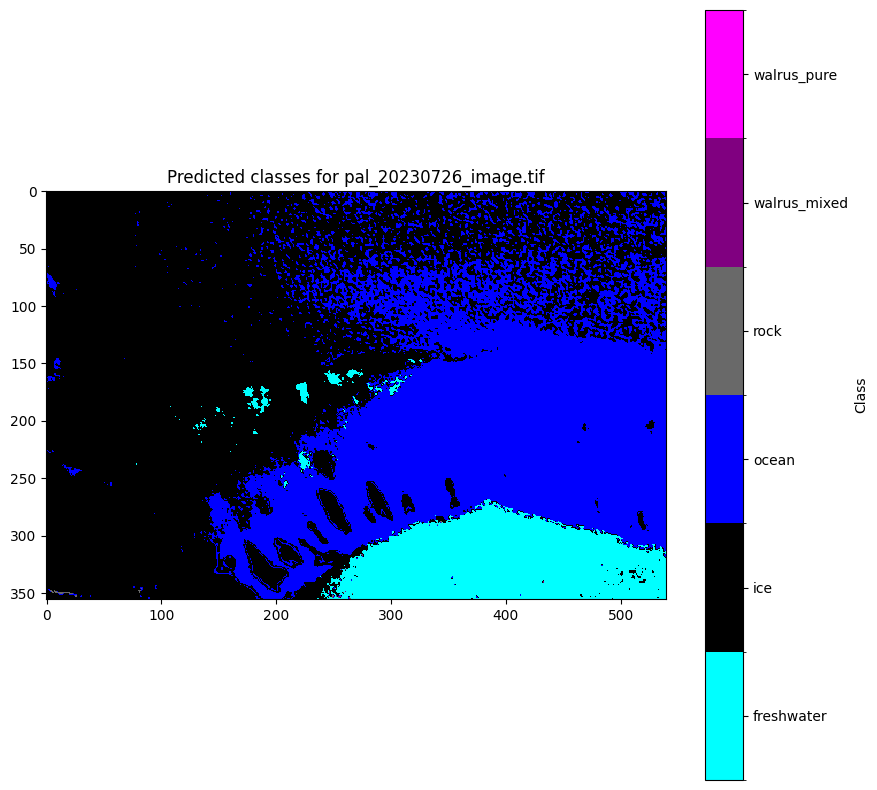

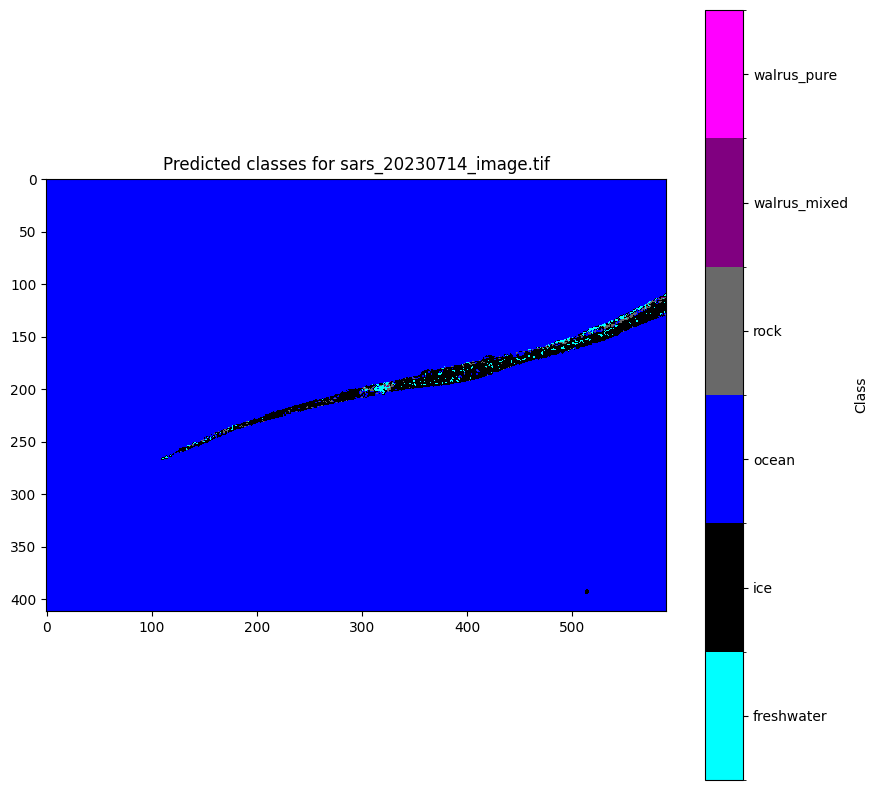

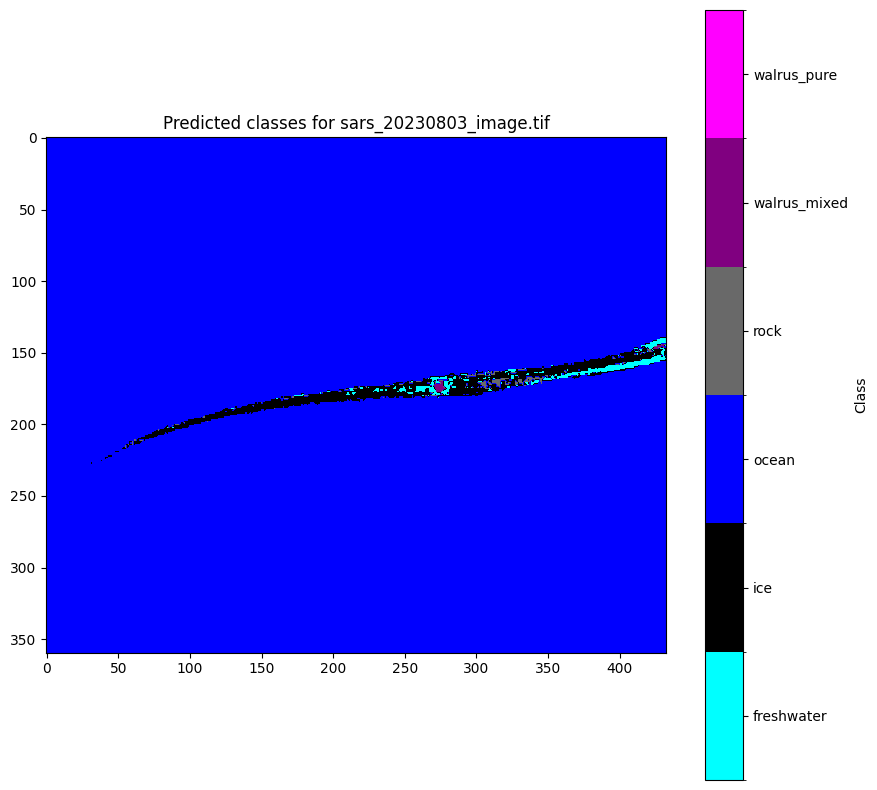

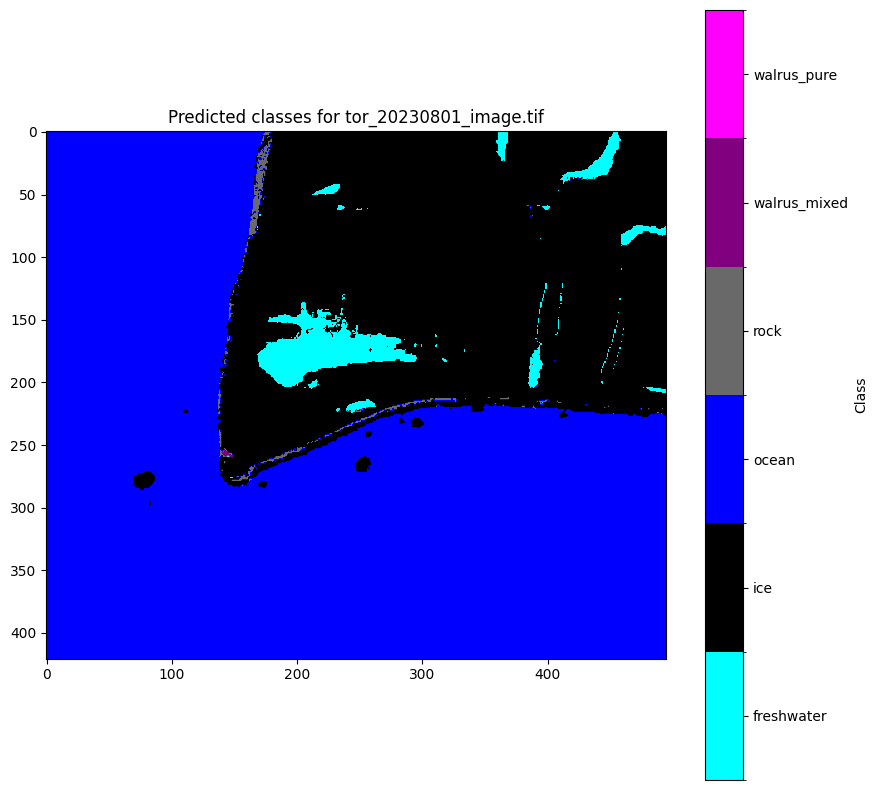

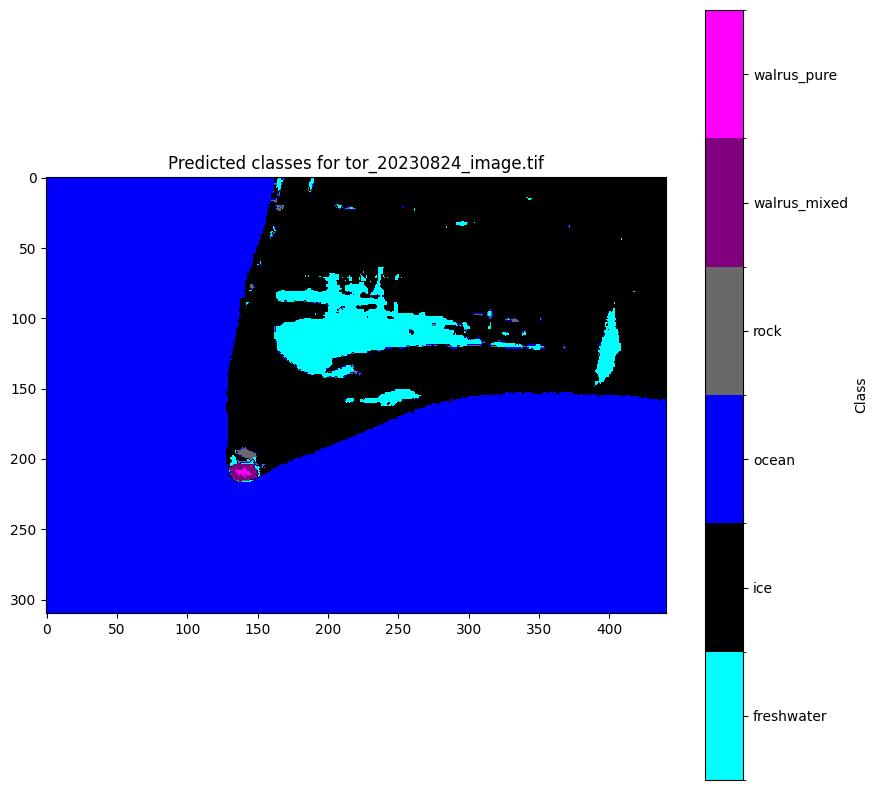

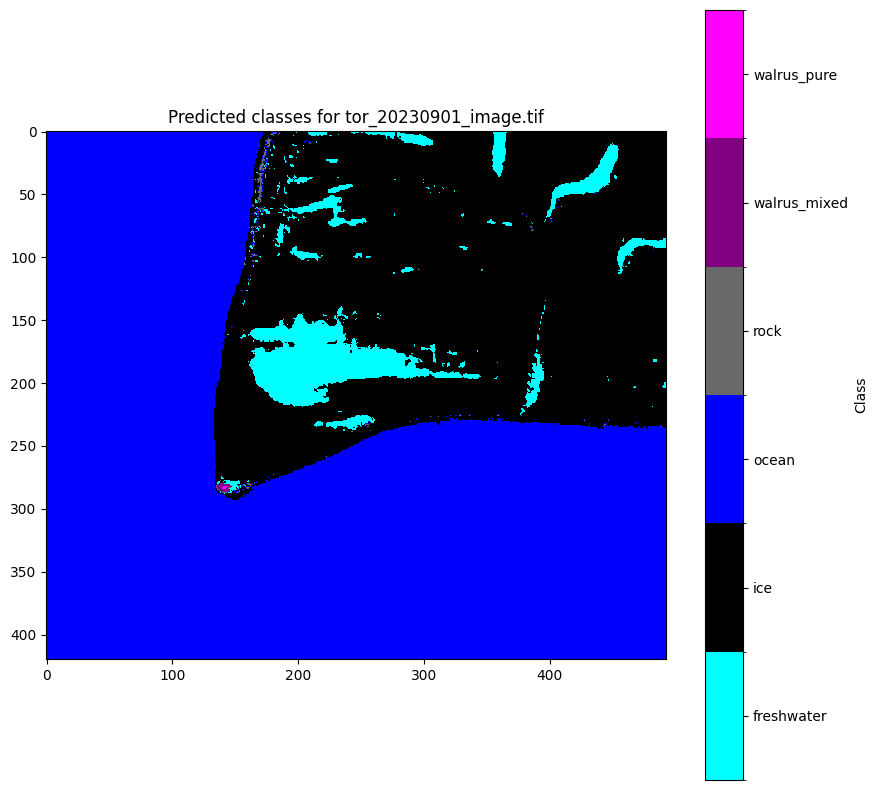

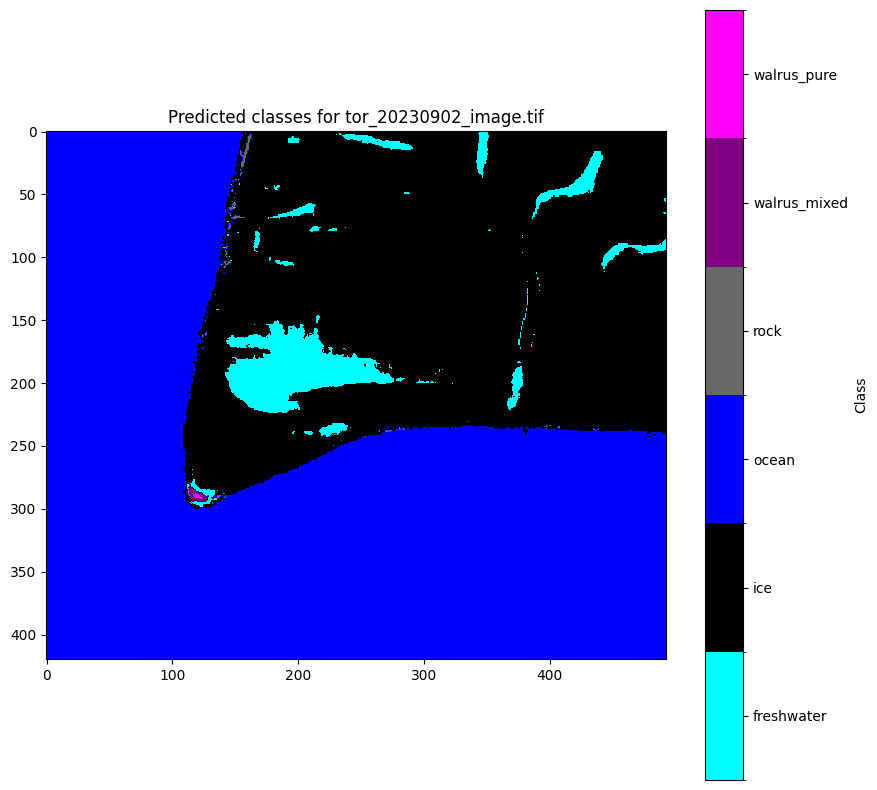

In [72]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue', 'stain': 'red'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(le.classes_)+1)-0.5, ncolors=len(le.classes_))

for image_path, predicted_image in predicted_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    plt.show()


In [3]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [4]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [5]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Sha

In [6]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [7]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.90      8044
         ice       0.98      0.99      0.98     60098
       ocean       1.00      1.00      1.00    155893
        rock       0.98      0.97      0.97     18474
walrus_mixed       1.00      0.28      0.44       178
 walrus_pure       0.86      0.92      0.89        13

    accuracy                           0.99    242700
   macro avg       0.95      0.84      0.86    242700
weighted avg       0.99      0.99      0.99    242700


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


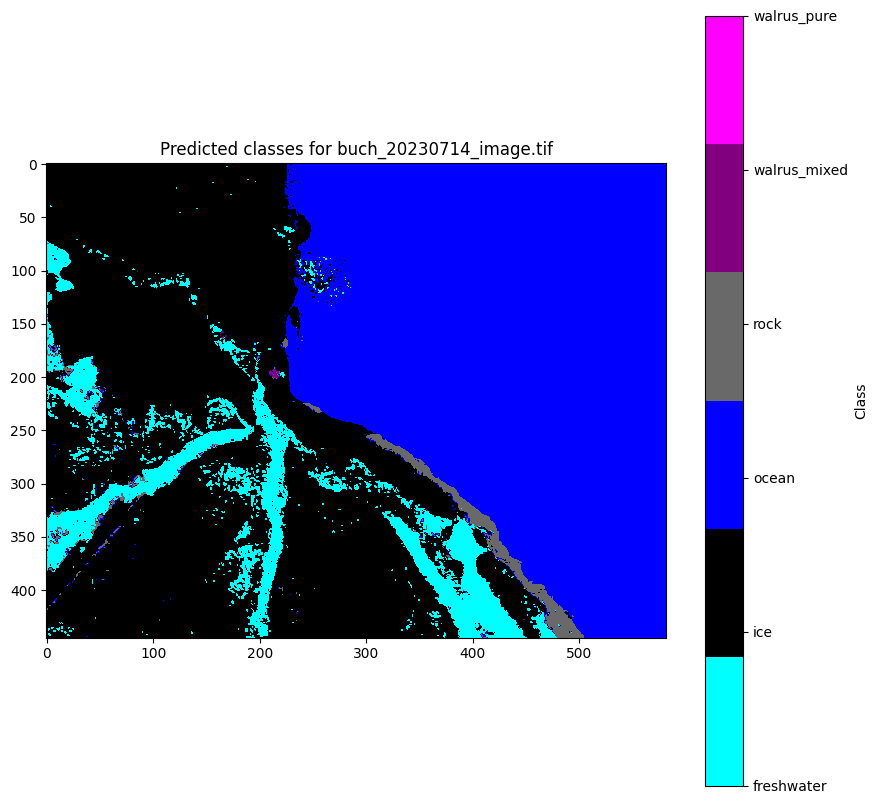

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


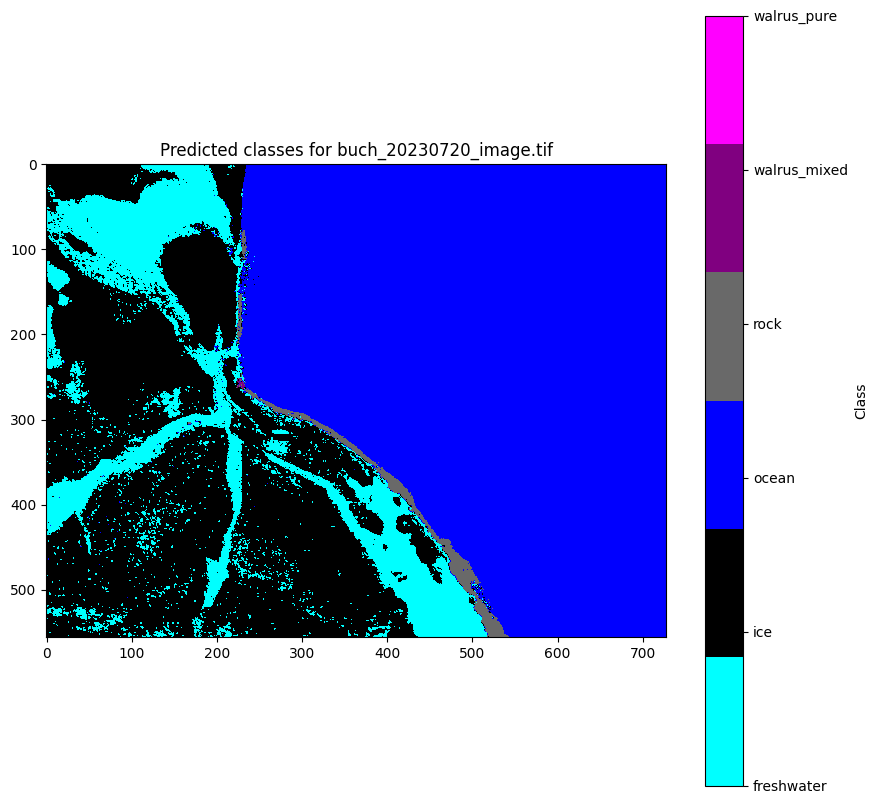

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


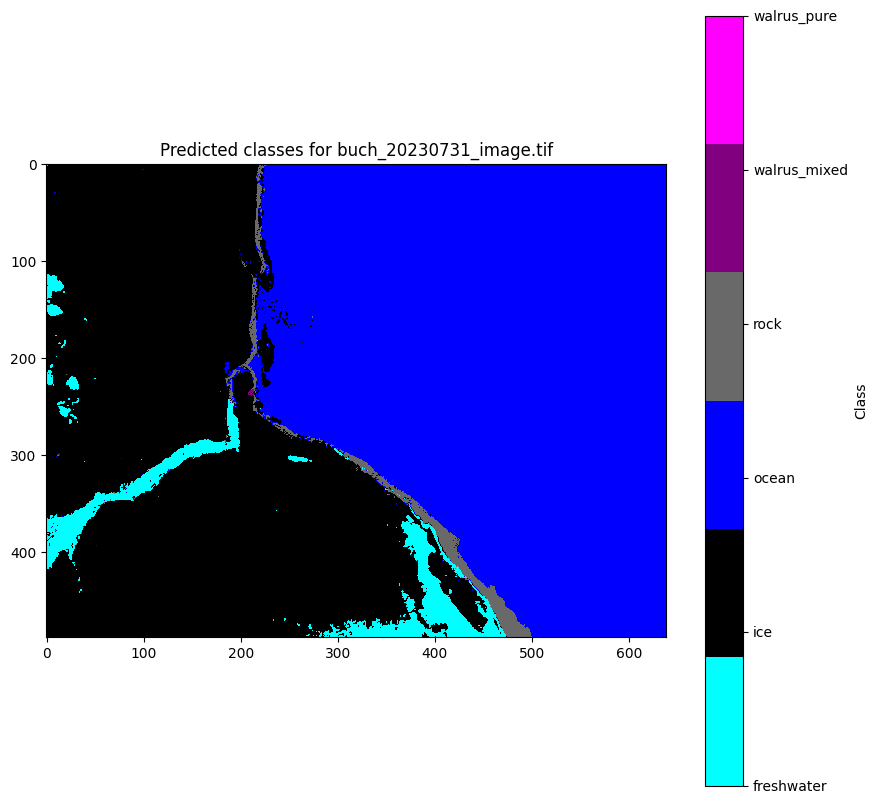

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


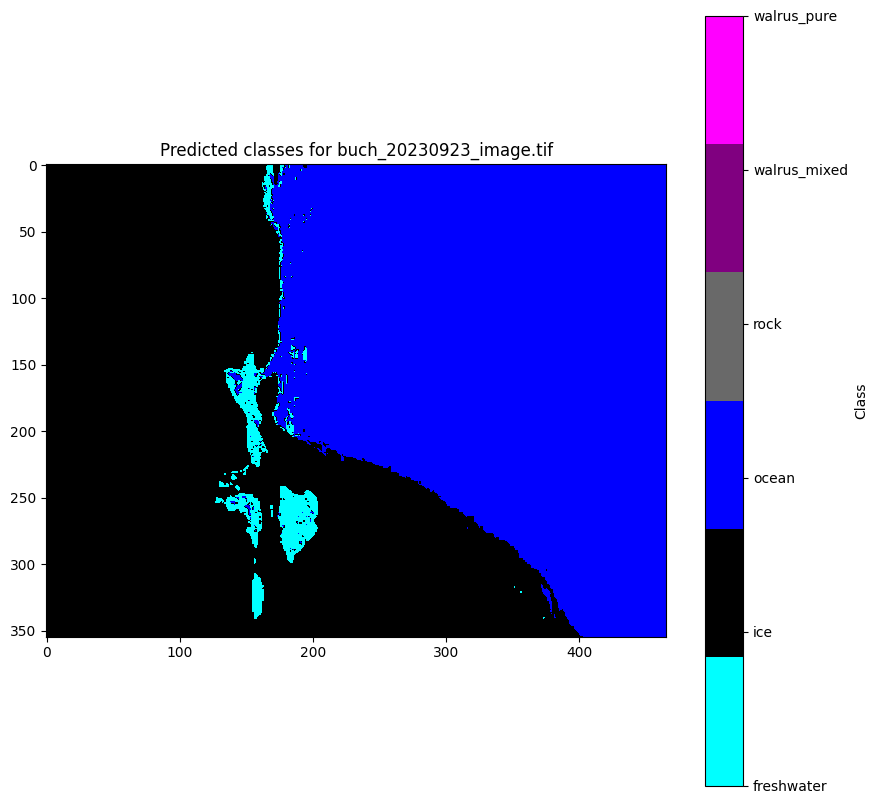

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


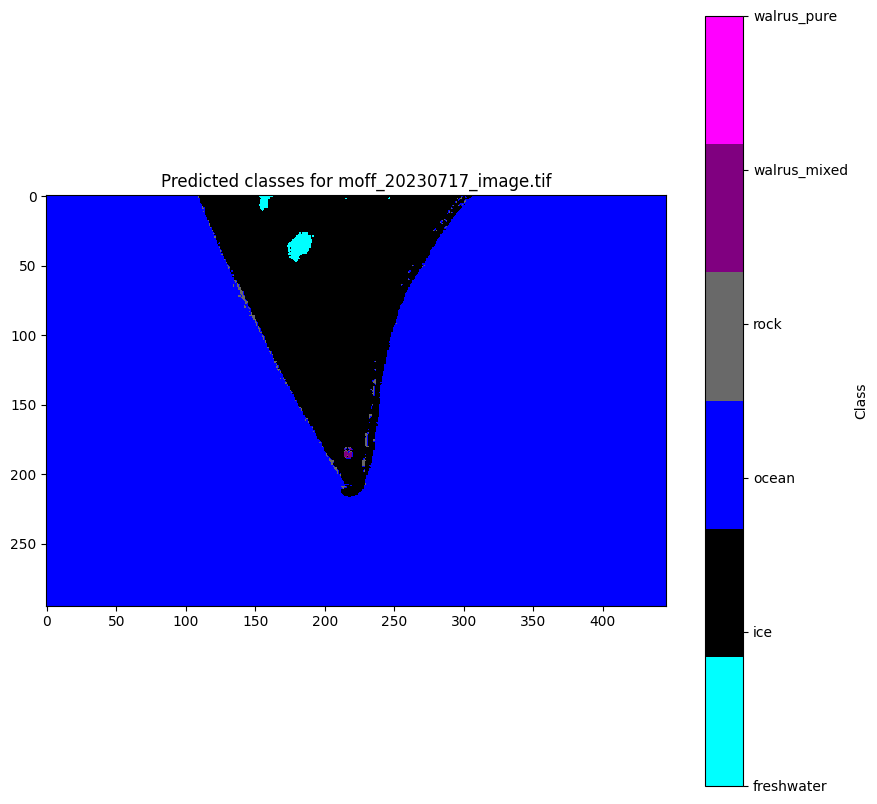

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


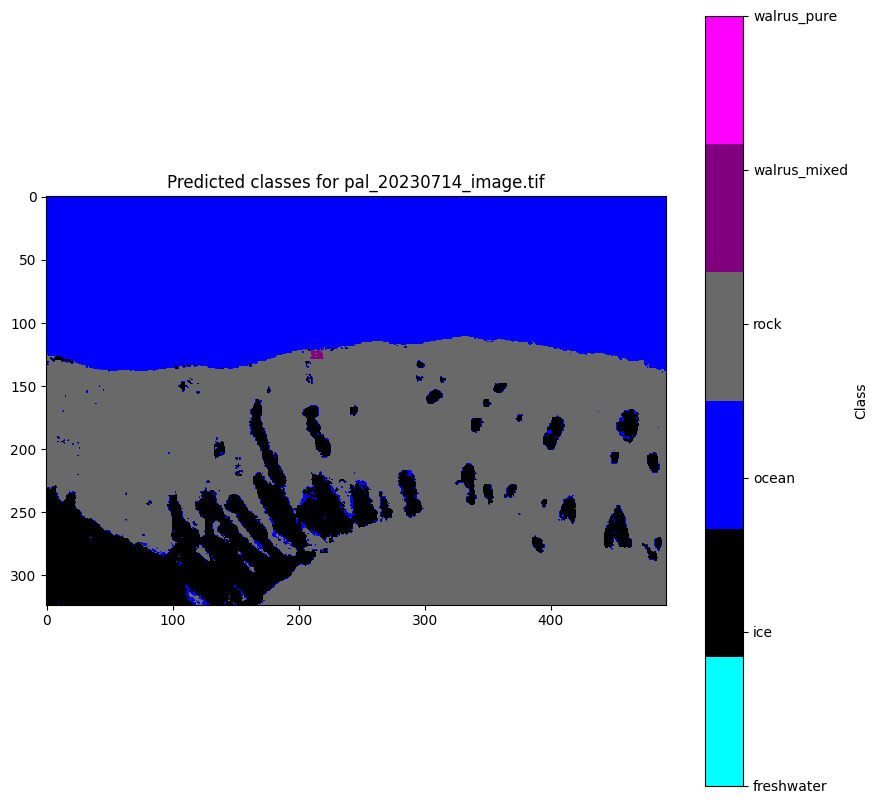

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


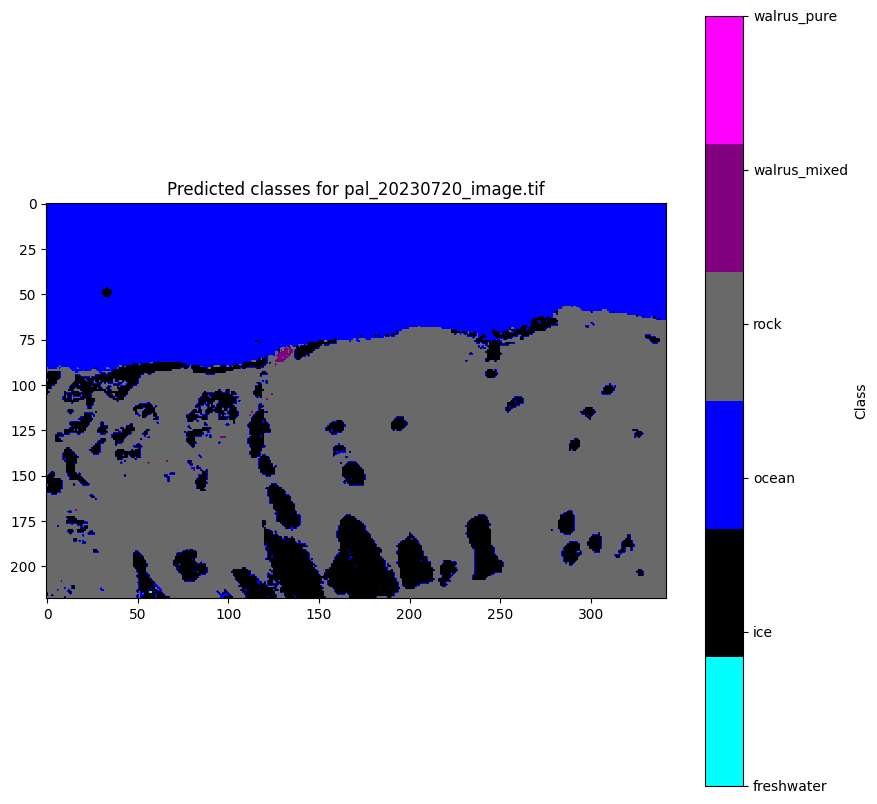

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


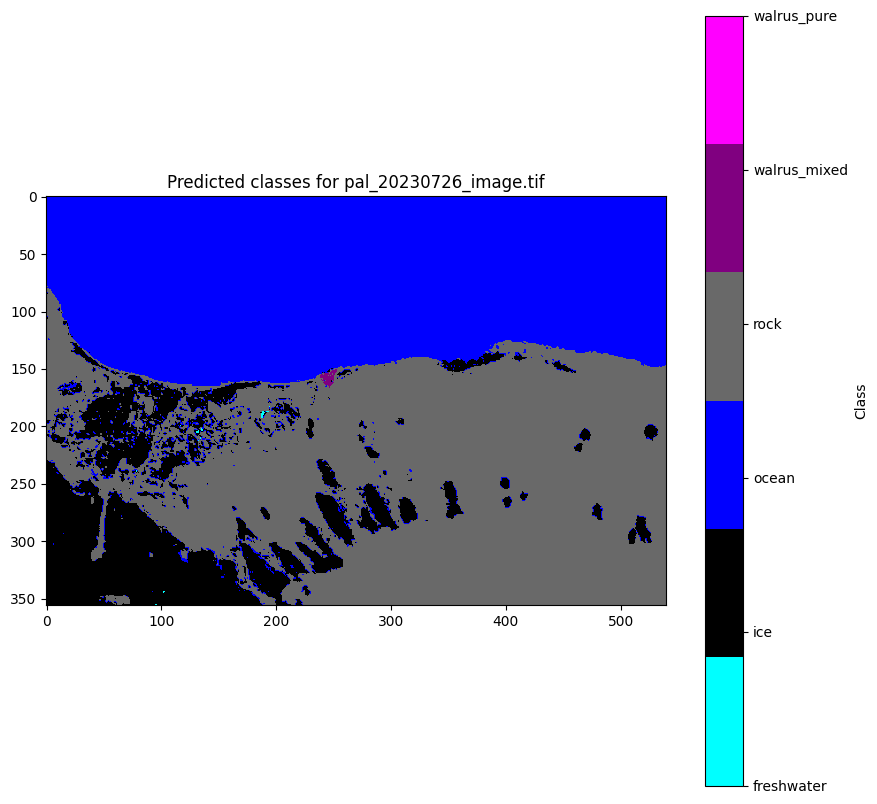

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


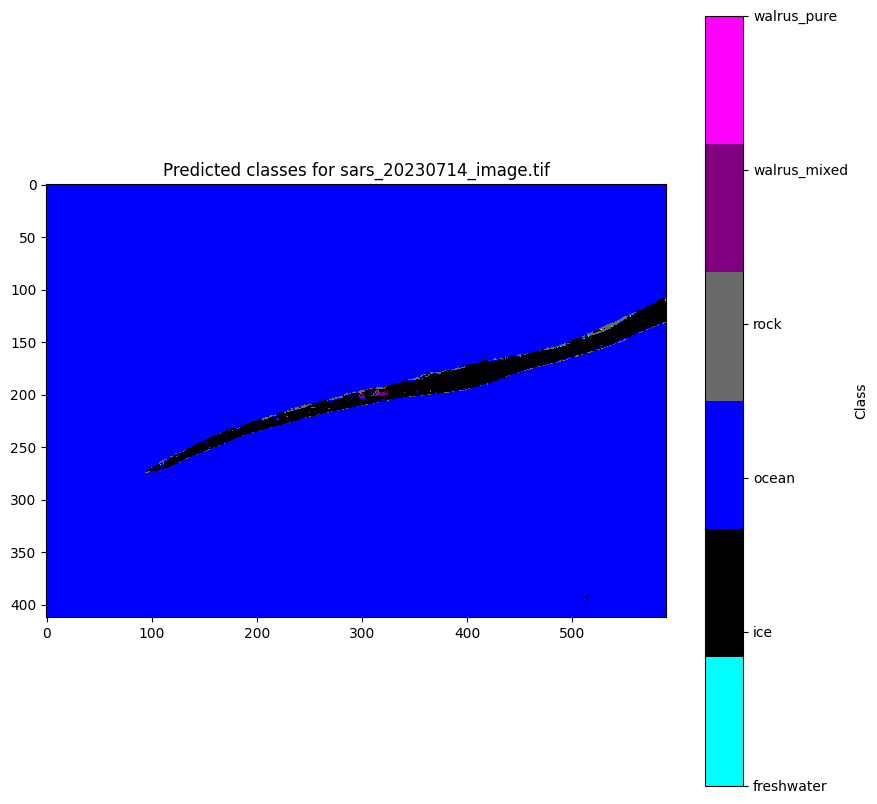

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


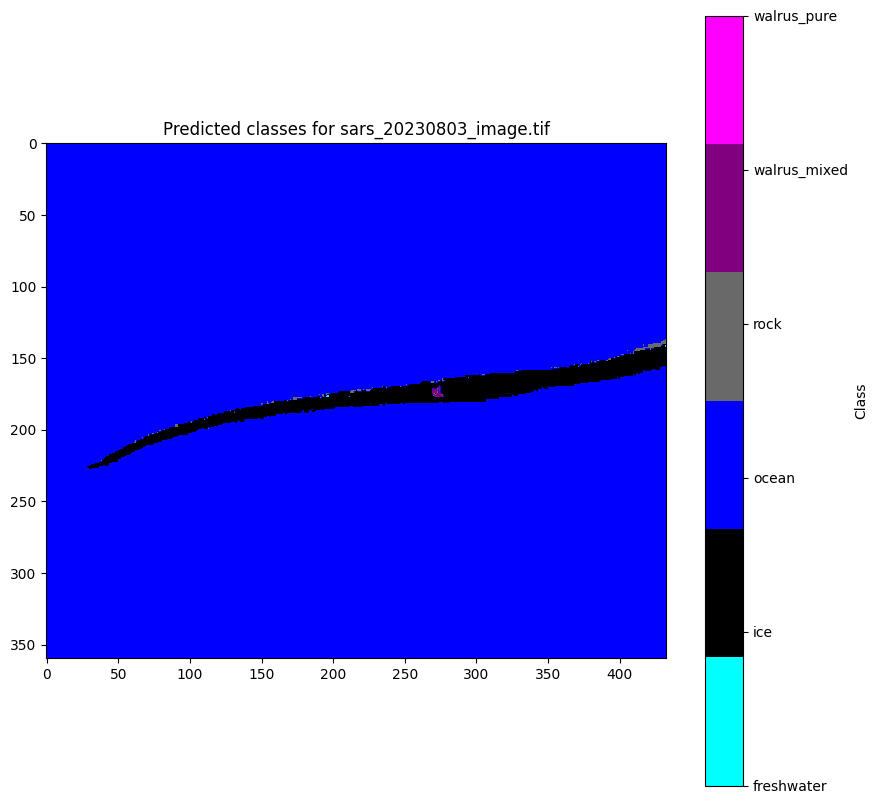

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


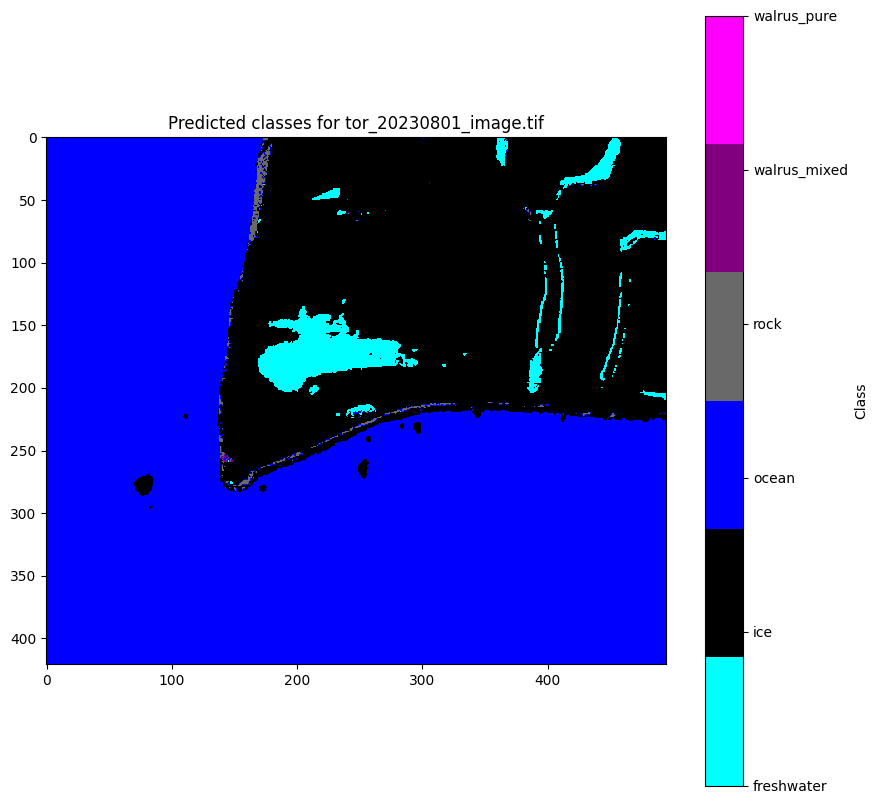

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


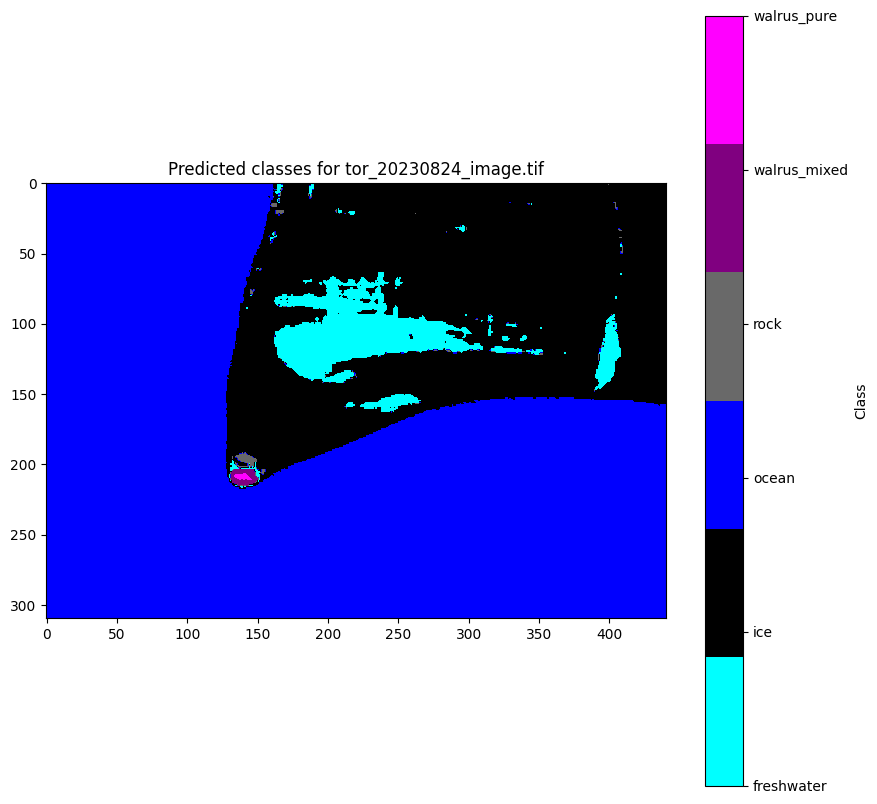

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


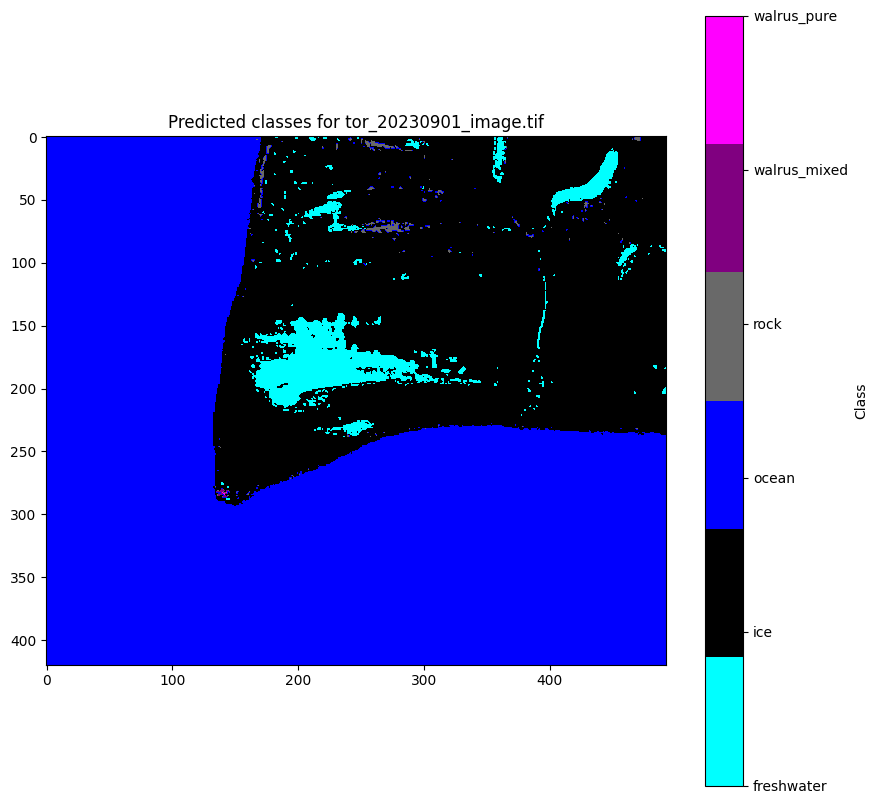

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


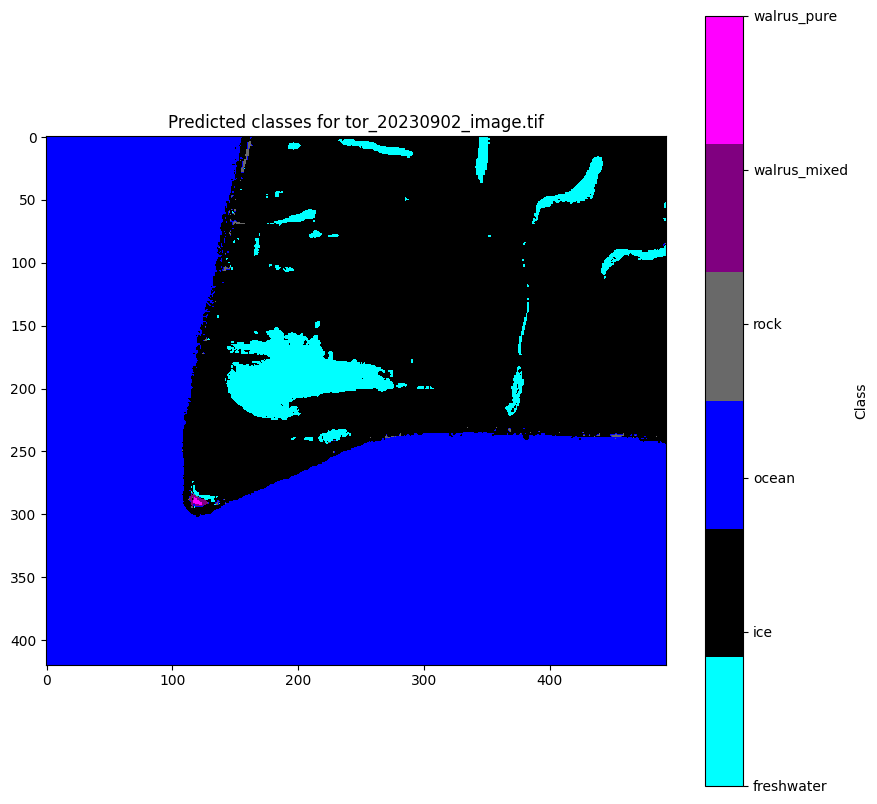

In [9]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()
